In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pandas as pd
print(pd.__version__)

0.20.3


In [4]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

1.3.0


In [5]:
import keras
print(keras.__version__)

Using TensorFlow backend.


2.0.9


In [6]:
import numpy as np

from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs

# http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html#sklearn.datasets.make_blobs

# https://www.welt.de/motor/news/article156991316/Unfallstatistik-2015.html
# http://www.openculture.com/2017/12/why-incompetent-people-think-theyre-amazing.html
# 0: young drivers with fast cars: red
# 1: reasonable drivers: green
# 2: a little bit older, more kilometers, general noise: yellow
# 3: really old drivers: red
# 4: young drivers: red
# 5: another green just to have a counter part to all the red ones: green
# 6: people who do not drive a lot: green
# 7: people who drive a lot: yellow
# 8: young people with slow cars: yellow

centers = [(200, 35, 50), (160, 50, 25), (170, 55, 30), (170, 75, 20), (170, 30, 30), (190, 45, 40), (160, 40, 15), (180, 50, 45), (140, 25, 15)]
cluster_std = [4, 9, 18, 8, 9, 5, 8, 12, 5]

X, y = make_blobs(n_samples=1500, n_features=3, centers=centers, random_state=42, cluster_std = cluster_std)

# http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html
# X, y = make_classification(n_features=3, n_redundant=0, n_informative=3,
#                              n_clusters_per_class=2, n_classes=3, random_state=42)

feature_names = ['max speed', 'age' ,'thousand km per year']
df = pd.DataFrame(X, columns=feature_names)
df = df.round()
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.clip.html

df['max speed'] = df['max speed'].clip(90,400)
df['age'] = df['age'].clip(18,90)
df['thousand km per year'] = df['thousand km per year'].clip(5,500)

X = df.as_matrix()

# merges clusters into one group
for group in np.nditer(y, op_flags=['readwrite']):
    if group == 3 or group == 4:
        group[...] = 0
    if group == 5 or group == 6:
        group[...] = 1
    if group == 7 or group == 8:
        group[...] = 2

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

In [9]:
# tiny little pieces of feature engeneering
from keras.utils.np_utils import to_categorical

num_categories = 3

y_train = to_categorical(y_train, num_categories)
y_test = to_categorical(y_test, num_categories)

In [10]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((900, 3), (900, 3), (600, 3), (600, 3))

In [11]:
# ignore this, it is just technical code
# should come from a lib, consider it to appear magically 
# http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

cmap_bold = ListedColormap(['#AA4444', '#006000', '#AAAA00'])
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#FFFFDD'])
font_size=25

def meshGrid(x_data, y_data):
    h = 1  # step size in the mesh
    x_min, x_max = x_data.min() - 1, x_data.max() + 1
    y_min, y_max = y_data.min() - 1, y_data.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return (xx,yy)
    
def plotPrediction(model, x_data, y_data, x_label, y_label, colors, title="", mesh=True):
    xx,yy = meshGrid(x_data, y_data)
    grid_X = np.array(np.c_[yy.ravel(), xx.ravel()])
#     print(grid_X)
    Z = model.predict(grid_X)
    Z = np.argmax(Z, axis=1)
#     print(Z)

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(20,10))
    if mesh:
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.scatter(x_data, y_data, c=np.argmax(colors, axis=1), cmap=cmap_bold, s=80, marker='o')
    plt.xlabel(x_label, fontsize=font_size)
    plt.ylabel(y_label, fontsize=font_size)
    plt.title(title, fontsize=font_size)

In [12]:
X_train_kmh_age = X_train[:, :2]
X_test_kmh_age = X_test[:, :2]

In [13]:
X_train_2_dim = X_train_kmh_age
X_test_2_dim = X_test_kmh_age

In [14]:
from keras.layers import Input
from keras.layers import Dense
from keras.models import Model
from keras.layers import Dropout

drop_out = 0.3

inputs = Input(name='input', shape=(2, ))
x = Dense(100, name='hidden1', activation='sigmoid')(inputs)
x = Dropout(drop_out)(x)
x = Dense(100, name='hidden2', activation='sigmoid')(x)
x = Dropout(drop_out)(x)
x = Dense(100, name='hidden3', activation='sigmoid')(x)
x = Dropout(drop_out)(x)
# x = Dense(100, name='hidden4', activation='sigmoid')(x)
# x = Dropout(drop_out)(x)
# x = Dense(100, name='hidden5', activation='sigmoid')(x)
# x = Dropout(drop_out)(x)
predictions = Dense(3, name='softmax', activation='softmax')(x)
model = Model(input=inputs, output=predictions)

# loss function: http://cs231n.github.io/linear-classify/#softmax
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2)                 0         
_________________________________________________________________
hidden1 (Dense)              (None, 100)               300       
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
hidden2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
hidden3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
__________

In [15]:
%time model.fit(X_train_2_dim, y_train, epochs=1000, validation_split=0.2, verbose=0, batch_size=100)

CPU times: user 47.9 s, sys: 3.67 s, total: 51.6 s
Wall time: 25.2 s


In [16]:
train_loss, train_accuracy = model.evaluate(X_train_2_dim, y_train, batch_size=100)
train_loss, train_accuracy

900/900 [==============================] - 0s 27us/step


(0.78291407558653092, 0.65777776638666785)

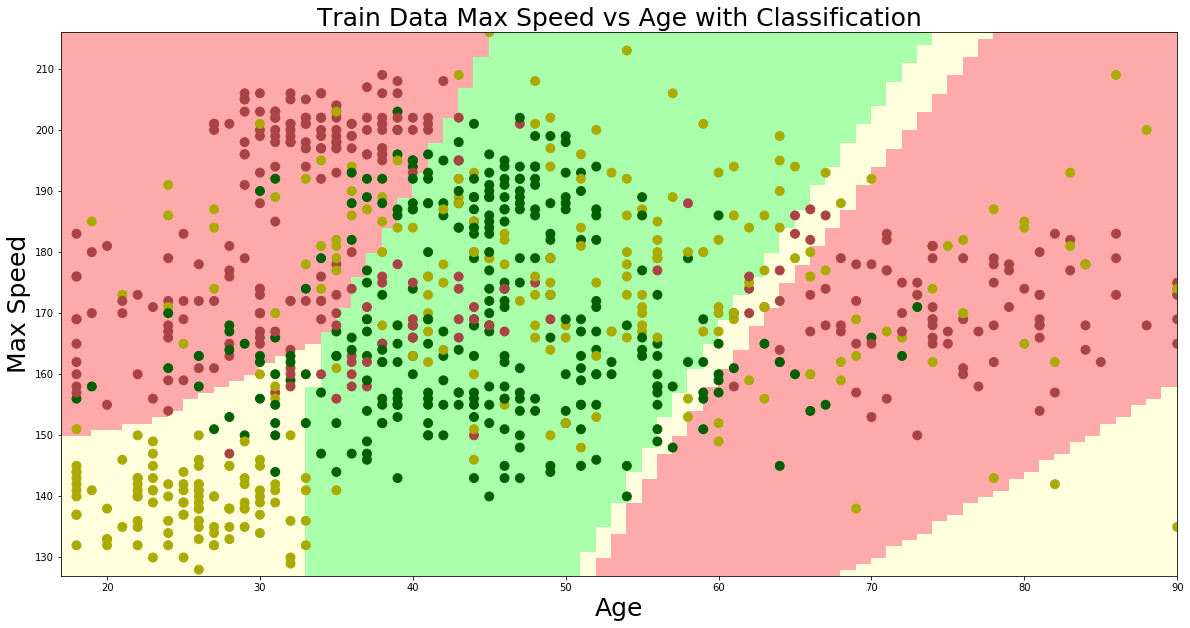

In [17]:
plotPrediction(model, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data Max Speed vs Age with Classification")

In [18]:
test_loss, test_accuracy = model.evaluate(X_test_2_dim, y_test, batch_size=100)
test_loss, test_accuracy

600/600 [==============================] - 0s 25us/step


(0.7622068623701731, 0.66500000158945716)

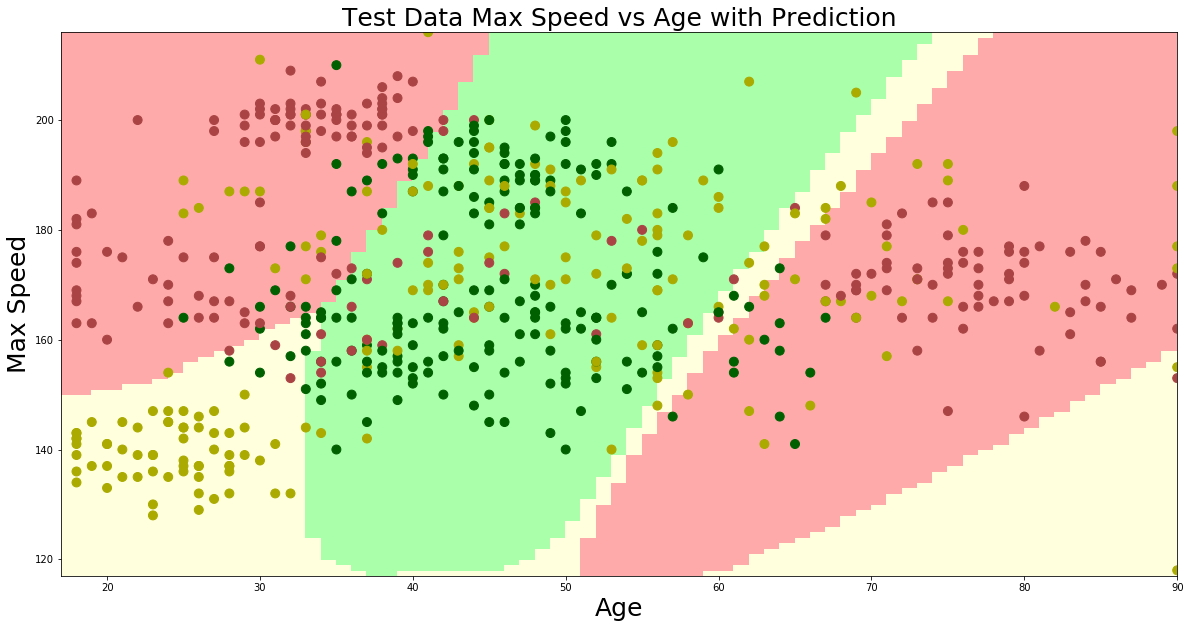

In [19]:
plotPrediction(model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data Max Speed vs Age with Prediction")

In [45]:
from keras.layers import Input
from keras.layers import Dense
from keras.models import Model
from keras.layers import Dropout

drop_out = 0.3

inputs = Input(name='input', shape=(3, ))
x = Dense(100, name='hidden1', activation='sigmoid')(inputs)
# x = Dropout(drop_out)(x)
x = Dense(100, name='hidden2', activation='sigmoid')(x)
# x = Dropout(drop_out)(x)
x = Dense(100, name='hidden3', activation='sigmoid')(x)
# x = Dropout(drop_out)(x)
# x = Dense(100, name='hidden4', activation='sigmoid')(x)
# x = Dropout(drop_out)(x)
# x = Dense(100, name='hidden5', activation='sigmoid')(x)
# x = Dropout(drop_out)(x)
predictions = Dense(3, name='softmax', activation='softmax')(x)
model = Model(input=inputs, output=predictions)

# loss function: http://cs231n.github.io/linear-classify/#softmax
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
%time model.fit(X_train, y_train, epochs=1000, validation_split=0.2, verbose=0, batch_size=100)

CPU times: user 45.2 s, sys: 2.89 s, total: 48.1 s
Wall time: 30.8 s


In [46]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=100)
train_loss, train_accuracy

900/900 [==============================] - 0s 99us/step


(0.65168817175759208, 0.74555555979410804)

In [47]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=100)
test_loss, test_accuracy

600/600 [==============================] - 0s 113us/step


(0.65172424912452698, 0.71500000357627869)

In [48]:
!rm -rf tf

In [50]:
import os
from keras import backend as K

# K.clear_session()

K.set_learning_phase(0)

# tf.app.flags.DEFINE_integer('model_version', 1, 'version number of the model.')
# tf.app.flags.DEFINE_string('work_dir', '/tmp', 'Working directory.')
# FLAGS = tf.app.flags.FLAGS

export_path_base = 'tf'
export_path = os.path.join(
  tf.compat.as_bytes(export_path_base),
  tf.compat.as_bytes(str(FLAGS.model_version)))

sess = K.get_session()

classification_inputs = tf.saved_model.utils.build_tensor_info(model.input)
classification_outputs_scores = tf.saved_model.utils.build_tensor_info(model.output)

from tensorflow.python.saved_model.signature_def_utils_impl import build_signature_def, predict_signature_def

signature = predict_signature_def(inputs={'inputs': model.input},
                                  outputs={'scores': model.output})

builder = tf.saved_model.builder.SavedModelBuilder(export_path)

builder.add_meta_graph_and_variables(
      sess, 
     tags=[tf.saved_model.tag_constants.SERVING],
      signature_def_map={
          tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY: signature
      })

builder.save()

b'tf/1/saved_model.pb'

In [51]:
!ls -lhR tf tf

tf:
total 0
drwxrwxrwx 0 root root 512 Dec 18 17:10 1

tf/1:
total 132K
-rwxrwxrwx 1 root root 130K Dec 18 17:10 saved_model.pb
drwxrwxrwx 0 root root  512 Dec 18 17:10 variables

tf/1/variables:
total 252K
-rwxrwxrwx 1 root root 245K Dec 18 17:10 variables.data-00000-of-00001
-rwxrwxrwx 1 root root  934 Dec 18 17:10 variables.index

tf:
total 0
drwxrwxrwx 0 root root 512 Dec 18 17:10 1

tf/1:
total 132K
-rwxrwxrwx 1 root root 130K Dec 18 17:10 saved_model.pb
drwxrwxrwx 0 root root  512 Dec 18 17:10 variables

tf/1/variables:
total 252K
-rwxrwxrwx 1 root root 245K Dec 18 17:10 variables.data-00000-of-00001
-rwxrwxrwx 1 root root  934 Dec 18 17:10 variables.index


In [52]:
!saved_model_cli show --dir tf/1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
inputs['inputs'] tensor_info:
    dtype: DT_FLOAT
    shape: (-1, 3)
    name: input:0
The given SavedModel SignatureDef contains the following output(s):
outputs['scores'] tensor_info:
    dtype: DT_FLOAT
    shape: (-1, 3)
    name: softmax/Softmax:0
Method name is: tensorflow/serving/predict


In [54]:
!saved_model_cli run --dir tf/1 --tag_set serve --signature_def serving_default --input_exprs 'inputs=[[160.0,46.0,10.0]]'

2017-12-18 17:12:09.154632: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
2017-12-18 17:12:09.154707: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2017-12-18 17:12:09.154729: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.
2017-12-18 17:12:09.154746: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX2 instructions, but these are available on your machine and could speed up CPU computations.
2017-12-18 17:12:09.154763: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't

In [ ]:
# https://cloud.google.com/ml-engine/docs/deploying-models

# gsutil cp -R tf/1 gs://insurance1
# create model and version at https://console.cloud.google.com/mlengine
# gcloud ml-engine predict --model=insurance_estimator --json-instances=./sample_insurance.json
# SCORES
# [0.9954029321670532, 0.004596732556819916, 3.3544753819114703e-07]

In [ ]:
# So weiter machen
# https://medium.com/@mark_riedl/introduction-to-neural-nets-without-the-brain-metaphor-874e7950bca0
# ohne Keras direkt mit TensorFlow

In [55]:
prediction = model.predict(X)
y_pred = np.argmax(prediction, axis=1)
y_pred

array([1, 1, 0, ..., 0, 0, 2])

In [57]:
y_true = y
y_true

array([1, 1, 0, ..., 1, 1, 2])

In [58]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
cm

array([[424,  62,  15],
       [ 67, 367,  66],
       [ 80, 110, 309]])

Text(33,0.5,'Ground Truth')

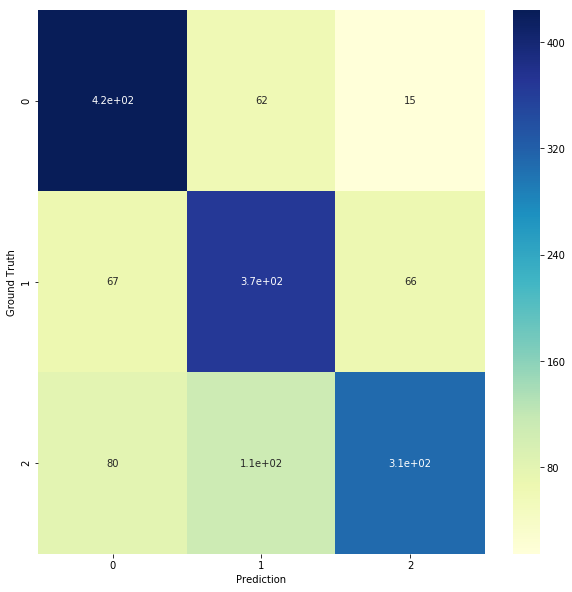

In [59]:
import seaborn as sns
sns.heatmap(cm, annot=True, cmap="YlGnBu")
figure = plt.gcf()
figure.set_size_inches(10, 10)
ax = figure.add_subplot(111)
ax.set_xlabel('Prediction')
ax.set_ylabel('Ground Truth')